In [116]:
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
path = "../../Result_json/"
file_list = os.listdir(path)
airflow_files = [file for file in file_list if file.startswith("airflow")]
airbyte_files = [file for file in file_list if file.startswith("airbyte")]

In [27]:
airflow_files

['airflow_populate_source.txt',
 'airflow_populate_target.txt',
 'airflow_status.txt']

In [107]:
source, target, status = [], [], []
for file, lst in zip(airflow_files, [source, target, status]):
    with open(path + file) as f:
        for line in f:
            lst.append(json.loads(line))

In [108]:
source = pd.DataFrame.from_dict(source, orient='columns').explode(["tables_names", "rows_count", "total_size_bytes"]).reset_index(drop=True)
target = pd.DataFrame.from_dict(target, orient='columns').explode(["tables_names", "rows_count", "total_size_bytes"]).reset_index(drop=True)
status = pd.DataFrame.from_dict(status, orient='columns')

In [109]:

# Source Fix types
source.rows_count = source.rows_count.astype(int)
source.total_size_bytes = source.total_size_bytes.astype(np.int64)
source.start_time = pd.to_datetime(source.start_time, unit='s')
source.end_time = pd.to_datetime(source.end_time, unit='s')
# Target Fix types
target.rows_count = target.rows_count.astype(int)
target.total_size_bytes = target.total_size_bytes.astype(np.int64)
# Source fix types
status.startTime = pd.to_datetime(status.startTime.str.replace("+00:00", ""), format="%Y-%m-%dT%H:%M:%S.%f")
status.endTime = pd.to_datetime(status.endTime.str.replace("+00:00", ""), format="%Y-%m-%dT%H:%M:%S.%f")

# Source create time_delta
source["time_delta"] = (source.end_time - source.start_time).dt.total_seconds()

source_grouped = source.groupby(["benchmark_id", "sf"]).agg({"rows_count": "sum", "total_size_bytes": "sum", "time_delta": "max"}).reset_index()
target_grouped = target.groupby(["benchmark_id", "sf"]).agg({"rows_count": "sum", "total_size_bytes": "sum"}).reset_index()

# join source and status
source_status = source[["benchmark_id", "sf"]].merge(status, left_on=["benchmark_id"], right_on=["benchmark_id"], how="inner")
source_status = source_status.groupby(["benchmark_id", "sf"]).TimeDelta.max().reset_index()

source_grouped.head(3)

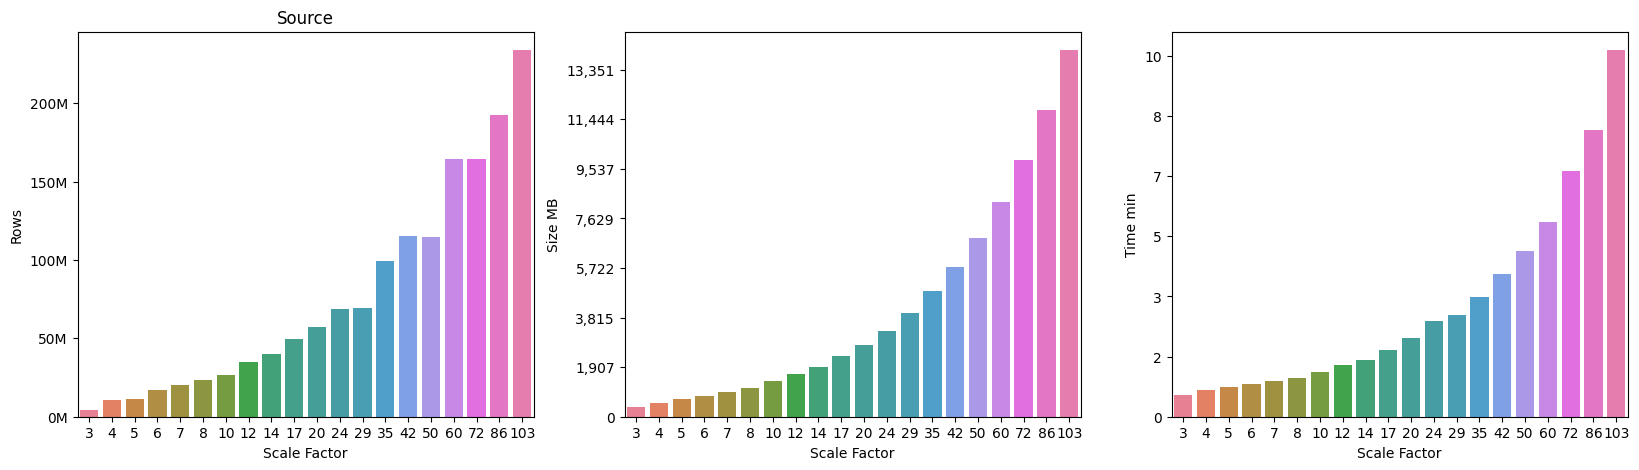

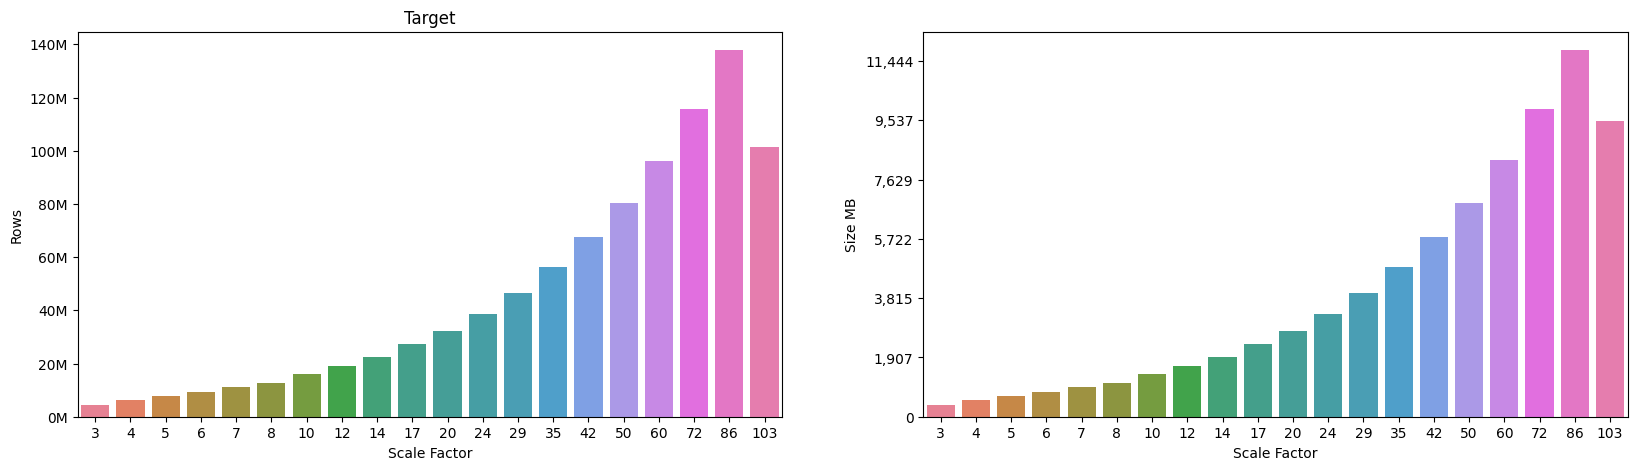

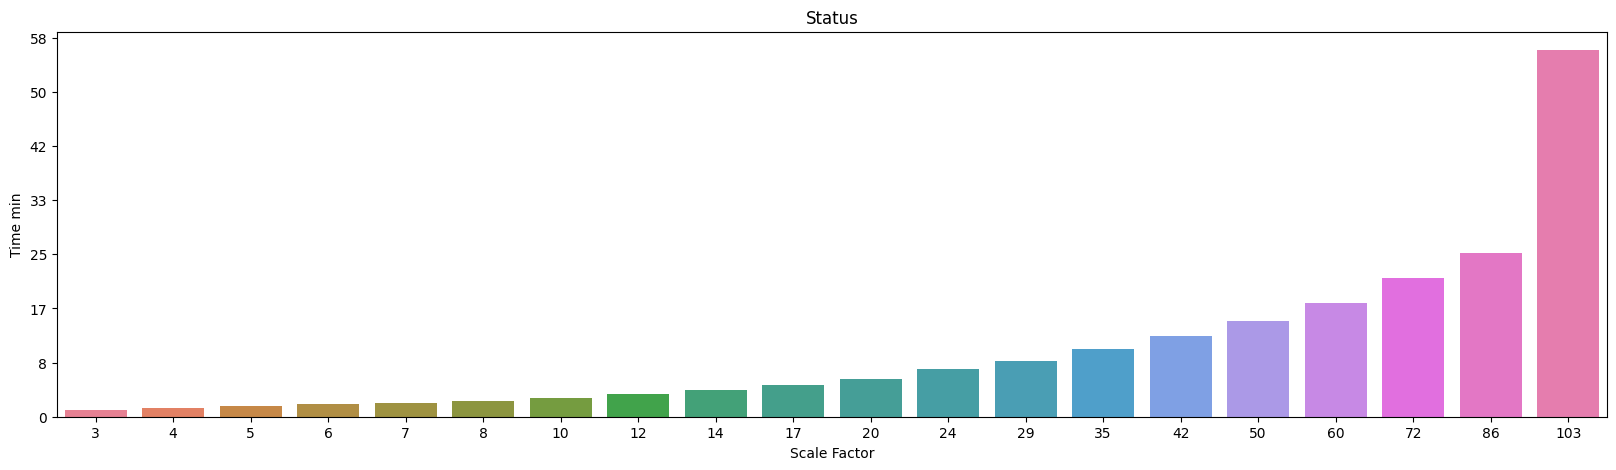

In [192]:

fig, ax = plt.subplots(1, 3, figsize=(20, 5))
for idx, col in enumerate(["rows_count", "total_size_bytes", "time_delta"]):
    sns.barplot(x="sf", y=col, hue="benchmark_id", data=source_grouped, ax=ax[idx], legend=False)
    if idx == 0:
        # Set y-axis scale to millions with separators
        ax[idx].yaxis.set_major_formatter(lambda x, pos: '{:,.0f}'.format(x/1000000) + 'M')
        ax[idx].set(ylabel="Rows", xlabel="Scale Factor", title="Source")
    elif idx == 1:
        # Divide by 1024 to get MB
        ax[idx].yaxis.set_major_formatter(lambda x, pos: '{:,.0f}'.format(x/1024/1024))
        ax[idx].set(ylabel="Size MB", xlabel="Scale Factor")
    else:
        ax[idx].yaxis.set_major_formatter(lambda x, pos: '{:,.0f}'.format(x/60))
        ax[idx].set(ylabel="Time min", xlabel="Scale Factor")
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(20, 5))
for idx, col in enumerate(["rows_count", "total_size_bytes"]):
    sns.barplot(x="sf", y=col, hue="benchmark_id", data=target_grouped, ax=ax[idx], legend=False)
    if idx == 0:
        # Set y-axis scale to millions with separators
        ax[idx].yaxis.set_major_formatter(lambda x, pos: '{:,.0f}'.format(x/1000000) + 'M')
        ax[idx].set(ylabel="Rows", xlabel="Scale Factor", title="Target")
    else:
        # Divide by 1024 to get MB
        ax[idx].yaxis.set_major_formatter(lambda x, pos: '{:,.0f}'.format(x/1024/1024))
        ax[idx].set(ylabel="Size MB", xlabel="Scale Factor")
plt.show()

fig, ax = plt.subplots(figsize=(20, 5))
sns.barplot(x="sf", y="TimeDelta", hue="benchmark_id", data=source_status, ax=ax, legend=False)
# Set y-axis scale to millions with separators
ax.yaxis.set_major_formatter(lambda x, pos: '{:,.0f}'.format(x/60))
ax.set(ylabel="Time min", xlabel="Scale Factor", title="Status")

plt.show()

In [197]:
source_grouped.sort_values(by="sf")

,benchmark_id,sf,rows_count,total_size_bytes,time_delta
0,MjAyMzExMDUyMDI4NTc=,3,4499457,406446080,36.734693
3,MjAyMzExMDUyMDMwNDI=,4,10632490,555917312,43.857795
4,MjAyMzExMDUyMDMyNTA=,5,11552708,698023936,49.893101
1,MjAyMzExMDUyMDM1MTg=,6,17138727,847421440,54.963556
2,MjAyMzExMDUyMDM4MDg=,7,20401444,990732288,58.979853
7,MjAyMzExMDUyMDQxMjM=,8,23664482,1140097024,65.166318
5,MjAyMzExMDUyMDQ0NTQ=,10,26623284,1431191552,74.189858
6,MjAyMzExMDUyMDQ5MDU=,12,35056635,1722720256,86.062638
8,MjAyMzExMDUyMDU0MDQ=,14,40127705,2016321536,95.138559
9,MjAyMzExMDUyMDU5NDU=,17,49725725,2455879680,111.194891


In [198]:
target_grouped.sort_values(by="sf")

,benchmark_id,sf,rows_count,total_size_bytes
0,MjAyMzExMDUyMDI4NTc=,3,4499457,403062784
3,MjAyMzExMDUyMDMwNDI=,4,6134538,551911424
4,MjAyMzExMDUyMDMyNTA=,5,7754006,694951936
1,MjAyMzExMDUyMDM1MTg=,6,9387216,843636736
2,MjAyMzExMDUyMDM4MDg=,7,11017209,987496448
7,MjAyMzExMDUyMDQxMjM=,8,12650546,1136238592
5,MjAyMzExMDUyMDQ0NTQ=,10,15904499,1428045824
6,MjAyMzExMDUyMDQ5MDU=,12,19156708,1719721984
8,MjAyMzExMDUyMDU0MDQ=,14,22420558,2012332032
9,MjAyMzExMDUyMDU5NDU=,17,27311563,2452996096


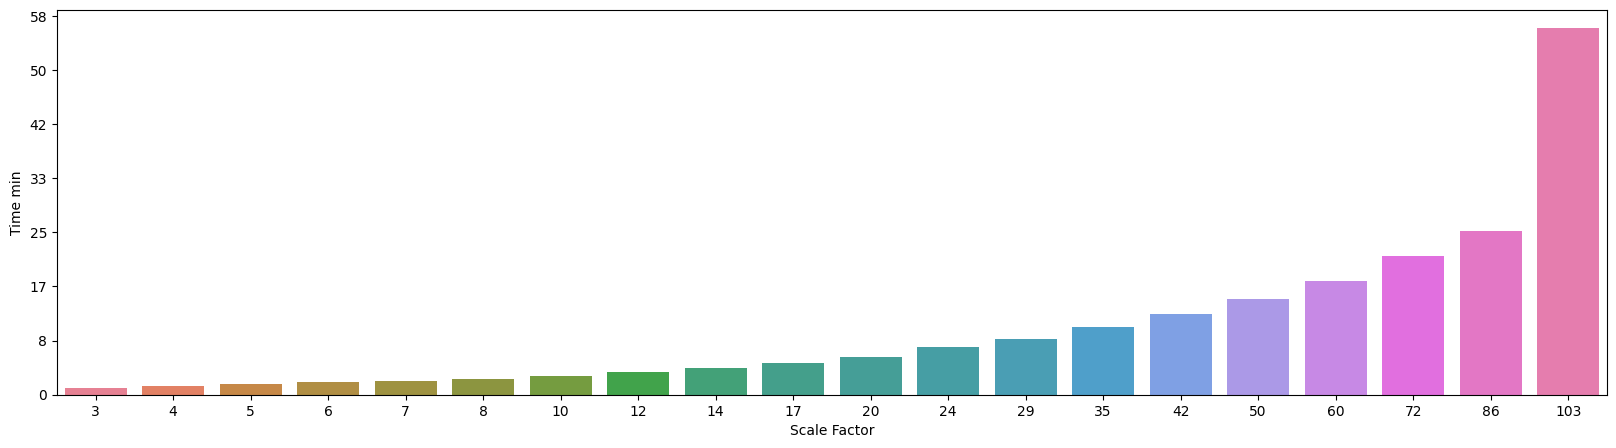

In [186]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
for idx, col in enumerate(["rows_count", "total_size_bytes"]):
    sns.barplot(x="sf", y=col, hue="benchmark_id", data=target_grouped, ax=ax[idx], legend=False)
    if idx == 0:
        # Set y-axis scale to millions with separators
        ax[idx].yaxis.set_major_formatter(lambda x, pos: '{:,.0f}'.format(x/1000000) + 'M')
        ax[idx].set(ylabel="Rows", xlabel="Scale Factor")
    else:
        # Divide by 1024 to get MB
        ax[idx].yaxis.set_major_formatter(lambda x, pos: '{:,.0f}'.format(x/1024/1024))
        ax[idx].set(ylabel="Size MB", xlabel="Scale Factor")
plt.show()

,sf,TimeDelta
0,3,65.73
1,4,80.57
2,5,97.06
3,6,113.36
4,7,129.45
5,8,145.30
6,10,175.76
7,12,208.19
8,14,242.24
9,17,294.42
